In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchvision  # If needed, reinstall PyTorch


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload your kaggle.json file from your local system


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chai2317","key":"947d1e01ac39fc0abeed7ada3cdf505b"}'}

In [ ]:
import shutil
import os

os.makedirs('/root/.kaggle/', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')


'/root/.kaggle/kaggle.json'

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download balraj98/massachusetts-buildings-dataset


Dataset URL: https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset
License(s): other
 99% 1.47G/1.49G [00:12<00:00, 76.5MB/s]
100% 1.49G/1.49G [00:12<00:00, 132MB/s] 


In [ ]:
import zipfile
with zipfile.ZipFile('massachusetts-buildings-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/Massachusetts_Buildings')


In [ ]:
import os
os.listdir('/content/drive/My Drive/Massachusetts_Buildings')


['label_class_dict.csv', 'metadata.csv', 'png', 'tiff']

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class MassachusettsBuildingsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '_mask.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:
import os
os.listdir('/content/drive/My Drive/Massachusetts_Buildings')


['label_class_dict.csv', 'metadata.csv', 'png', 'tiff']

In [ ]:
import os

print("Contents of png folder:")
print(os.listdir('/content/drive/My Drive/Massachusetts_Buildings/png'))

print("\nContents of tiff folder:")
print(os.listdir('/content/drive/My Drive/Massachusetts_Buildings/tiff'))


Contents of png folder:
['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']

Contents of tiff folder:
['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']


In [ ]:
import os

image_files = sorted(os.listdir('/content/drive/My Drive/Massachusetts_Buildings/png/train'))[:10]
mask_files = sorted(os.listdir('/content/drive/My Drive/Massachusetts_Buildings/tiff/train_labels'))[:10]

print("Sample image filenames:", image_files)
print("Sample mask filenames:", mask_files)


Sample image filenames: ['22678915_15.png', '22678930_15.png', '22678945_15.png', '22678960_15.png', '22678975_15.png', '22678990_15.png', '22679005_15.png', '22679020_15.png', '22679035_15.png', '22679050_15.png']
Sample mask filenames: ['22678915_15.tif', '22678930_15.tif', '22678945_15.tif', '22678960_15.tif', '22678975_15.tif', '22678990_15.tif', '22679005_15.tif', '22679020_15.tif', '22679035_15.tif', '22679050_15.tif']


In [ ]:
class MassachusettsBuildingsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = base_name + '.tif'
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom Dataset Class
class MassachusettsBuildingsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = base_name + '.tif'
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [ ]:
train_image_dir = "/content/drive/My Drive/Massachusetts_Buildings/png/train"
train_mask_dir = "/content/drive/My Drive/Massachusetts_Buildings/tiff/train_labels"
val_image_dir = "/content/drive/My Drive/Massachusetts_Buildings/png/val"
val_mask_dir = "/content/drive/My Drive/Massachusetts_Buildings/tiff/val_labels"

train_dataset = MassachusettsBuildingsDataset(train_image_dir, train_mask_dir, train_transform, train_transform)
val_dataset = MassachusettsBuildingsDataset(val_image_dir, val_mask_dir, val_transform, val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [ ]:
import torch.nn as nn
import torch

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(n_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.maxpool(c1))
        c3 = self.down3(self.maxpool(c2))
        c4 = self.down4(self.maxpool(c3))

        bottleneck = self.bottleneck(self.maxpool(c4))

        u1 = self.up1(bottleneck)
        u1 = self.conv1(torch.cat([u1, c4], dim=1))

        u2 = self.up2(u1)
        u2 = self.conv2(torch.cat([u2, c3], dim=1))

        u3 = self.up3(u2)
        u3 = self.conv3(torch.cat([u3, c2], dim=1))

        u4 = self.up4(u3)
        u4 = self.conv4(torch.cat([u4, c1], dim=1))

        return torch.sigmoid(self.final_conv(u4))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Dataset definition with proper mask filename handling
class MassachusettsBuildingsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = base_name + '.tif'
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Define transforms (resize to manageable size)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Paths - adjust if necessary
train_image_dir = "/content/drive/My Drive/Massachusetts_Buildings/png/train"
train_mask_dir = "/content/drive/My Drive/Massachusetts_Buildings/tiff/train_labels"

# Create dataset and dataloader
train_dataset = MassachusettsBuildingsDataset(train_image_dir, train_mask_dir, transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Define U-Net components
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(n_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.maxpool(c1))
        c3 = self.down3(self.maxpool(c2))
        c4 = self.down4(self.maxpool(c3))
        bottleneck = self.bottleneck(self.maxpool(c4))
        u1 = self.up1(bottleneck)
        u1 = self.conv1(torch.cat([u1, c4], dim=1))
        u2 = self.up2(u1)
        u2 = self.conv2(torch.cat([u2, c3], dim=1))
        u3 = self.up3(u2)
        u3 = self.conv3(torch.cat([u3, c2], dim=1))
        u4 = self.up4(u3)
        u4 = self.conv4(torch.cat([u4, c1], dim=1))
        return torch.sigmoid(self.final_conv(u4))

# Prepare device, model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with checkpoint saving every 10 epochs
num_epochs = 50
checkpoint_dir = "/content/drive/My Drive/Massachusetts_Buildings/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

print("Training complete.")


Epoch [1/50] Loss: 0.5473
Epoch [2/50] Loss: 0.3754
Epoch [3/50] Loss: 0.3222
Epoch [4/50] Loss: 0.3040
Epoch [5/50] Loss: 0.2929
Epoch [6/50] Loss: 0.2809
Epoch [7/50] Loss: 0.2765
Epoch [8/50] Loss: 0.2708
Epoch [9/50] Loss: 0.2694
Epoch [10/50] Loss: 0.2642
Saved checkpoint: /content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_10.pth
Epoch [11/50] Loss: 0.2625
Epoch [12/50] Loss: 0.2629
Epoch [13/50] Loss: 0.2603
Epoch [14/50] Loss: 0.2623
Epoch [15/50] Loss: 0.2536
Epoch [16/50] Loss: 0.2577
Epoch [17/50] Loss: 0.2500
Epoch [18/50] Loss: 0.2527
Epoch [19/50] Loss: 0.2485
Epoch [20/50] Loss: 0.2481
Saved checkpoint: /content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_20.pth
Epoch [21/50] Loss: 0.2448
Epoch [22/50] Loss: 0.2434
Epoch [23/50] Loss: 0.2472
Epoch [24/50] Loss: 0.2454
Epoch [25/50] Loss: 0.2433
Epoch [26/50] Loss: 0.2509
Epoch [27/50] Loss: 0.2467
Epoch [28/50] Loss: 0.2490
Epoch [29/50] Loss: 0.2483
Epoch [30/50] Loss: 0.2497
Saved c

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score


In [ ]:
# Load model (adjust path if needed)
model_path = "/content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_50.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model loaded successfully from:", model_path)


Model loaded successfully from: /content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_50.pth


In [ ]:
def dice_coeff(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou_score(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / (union + 1e-8)


In [ ]:
# Validation data directories
val_image_dir = "/content/drive/My Drive/Massachusetts_Buildings/png/val"
val_mask_dir = "/content/drive/My Drive/Massachusetts_Buildings/tiff/val_labels"

val_dataset = MassachusettsBuildingsDataset(
    val_image_dir, val_mask_dir, transform, mask_transform
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

dice_scores = []
iou_scores = []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        preds = preds.squeeze().cpu().numpy()
        masks = masks.squeeze().cpu().numpy()

        dice = dice_coeff(preds, masks)
        iou = iou_score(preds, masks)
        dice_scores.append(dice)
        iou_scores.append(iou)

print(f"Average Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Average IoU Score: {np.mean(iou_scores):.4f}")


Average Dice Coefficient: 0.6772
Average IoU Score: 0.5121


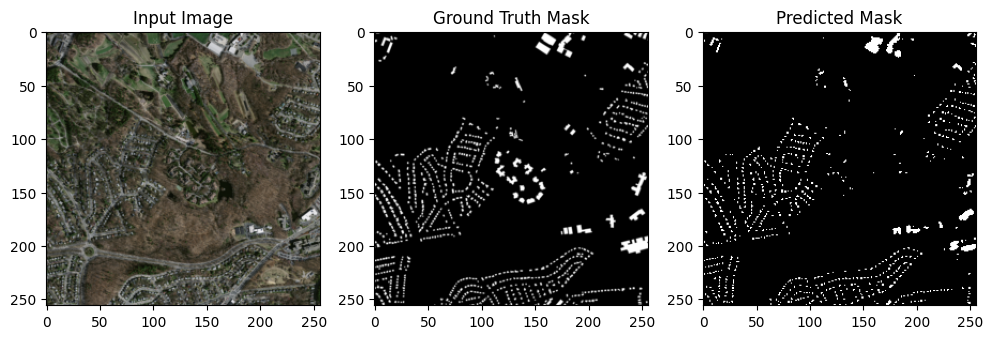

In [ ]:
model.eval()
with torch.no_grad():
    # use a valid index (0 to len(val_dataset)-1)
    img, mask = val_dataset[0]
    inp = img.unsqueeze(0).to(device)
    pred = model(inp)
    pred_mask = (pred.squeeze().cpu().numpy() > 0.5)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")

plt.show()


In [ ]:
import cv2

output_dir = "/content/drive/My Drive/Massachusetts_Buildings/predictions"
os.makedirs(output_dir, exist_ok=True)

for i, (image, mask) in enumerate(val_dataset):
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

    cv2.imwrite(f"{output_dir}/prediction_{i+1}.png", pred_mask)

print(f"Predictions saved in: {output_dir}")


Predictions saved in: /content/drive/My Drive/Massachusetts_Buildings/predictions


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
checkpoint_path = "/content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_50.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"Loaded model from: {checkpoint_path}")


Loaded model from: /content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_50.pth


In [ ]:
val_image_dir = "/content/drive/My Drive/Massachusetts_Buildings/png/val"
val_mask_dir = "/content/drive/My Drive/Massachusetts_Buildings/tiff/val_labels"

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
val_dataset = MassachusettsBuildingsDataset(val_image_dir, val_mask_dir, val_transform, val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [ ]:
import numpy as np

def dice_coeff(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou_score(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / (union + 1e-8)


In [ ]:
dice_scores = []
iou_scores = []

model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(val_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs_np = outputs.squeeze().cpu().numpy()
        masks_np = masks.squeeze().cpu().numpy()

        dice = dice_coeff(outputs_np, masks_np)
        iou = iou_score(outputs_np, masks_np)
        dice_scores.append(dice)
        iou_scores.append(iou)
        print(f"Image {idx}: Dice={dice:.4f} IoU={iou:.4f}")

print(f"\nAverage Dice: {np.mean(dice_scores):.4f}")
print(f"Average IoU: {np.mean(iou_scores):.4f}")


Image 0: Dice=0.6584 IoU=0.4907
Image 1: Dice=0.6710 IoU=0.5049
Image 2: Dice=0.6938 IoU=0.5311
Image 3: Dice=0.6855 IoU=0.5215

Average Dice: 0.6772
Average IoU: 0.5121


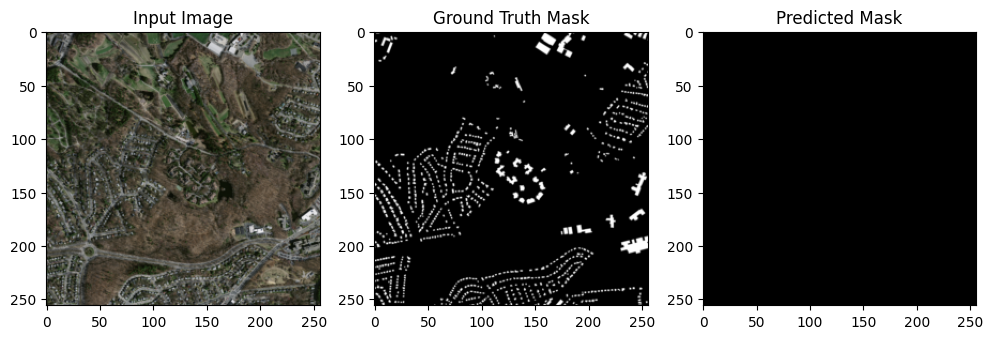

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # Change index to visualize other images (range: 0 to len(val_dataset)-1)
img, mask = val_dataset[idx]
with torch.no_grad():
    inp = img.unsqueeze(0).to(device)
    pred = model(inp)
    pred_mask = (pred.squeeze().cpu().numpy() > 0.5)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")

plt.show()


In [ ]:
# Required imports
import torch
import torch.optim as optim
import os

# Initialize device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
checkpoint_path = "/content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_50.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Optimizer (resume with same settings as before)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()
    def forward(self, pred, target):
        smooth = 1.
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        return 1 - dice + self.bce(pred, target)


In [ ]:
criterion = DiceBCELoss()


In [ ]:
num_epochs = 100
start_epoch = 50
checkpoint_dir = "/content/drive/My Drive/Massachusetts_Buildings/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)

    # Validation metrics calculation (optional, see previous cells)
    model.eval()
    dice_scores, iou_scores = [], []
    with torch.no_grad():
        for val_img, val_mask in val_loader:
            val_img, val_mask = val_img.to(device), val_mask.to(device)
            pred = model(val_img)
            pred_np, mask_np = pred.squeeze().cpu().numpy(), val_mask.squeeze().cpu().numpy()
            dice_scores.append(dice_coeff(pred_np, mask_np))
            iou_scores.append(iou_score(pred_np, mask_np))
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} | Val Dice: {avg_dice:.4f} | Val IoU: {avg_iou:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Checkpoint saved: {save_path}")

print("Continuing training complete.")


Epoch [51/100] Loss: 1.2679 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [52/100] Loss: 1.2330 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [53/100] Loss: 1.2239 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [54/100] Loss: 1.2099 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [55/100] Loss: 1.2166 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [56/100] Loss: 1.2080 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [57/100] Loss: 1.2072 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [58/100] Loss: 1.2009 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [59/100] Loss: 1.1984 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [60/100] Loss: 1.2065 | Val Dice: 0.0000 | Val IoU: 0.0000
Checkpoint saved: /content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_60.pth
Epoch [61/100] Loss: 1.2085 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [62/100] Loss: 1.2041 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [63/100] Loss: 1.2206 | Val Dice: 0.0000 | Val IoU: 0.0000
Epoch [64/100] Loss: 1.2111 | Val Dice: 0.0000 | Val IoU: 0

In [ ]:
model = UNet().to(device)
checkpoint_path = "/content/drive/My Drive/Massachusetts_Buildings/checkpoints/unet_epoch_50.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))


<All keys matched successfully>

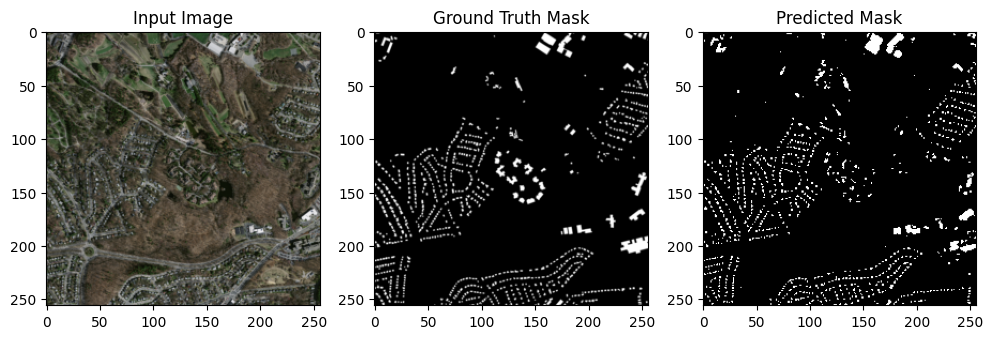

In [ ]:
# Sample code to evaluate and visualize
import matplotlib.pyplot as plt

idx = 0  # change index to explore other images
img, mask = val_dataset[idx]
with torch.no_grad():
    inp = img.unsqueeze(0).to(device)
    pred = model(inp)
    pred_mask = (pred.squeeze().cpu().numpy() > 0.5)

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Input Image")
plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth Mask")
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()


In [ ]:
import cv2
import os

output_dir = "/content/drive/My Drive/Massachusetts_Buildings/predictions"
os.makedirs(output_dir, exist_ok=True)

for i in range(len(val_dataset)):
    img, _ = val_dataset[i]
    with torch.no_grad():
        inp = img.unsqueeze(0).to(device)
        pred = model(inp)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255
        cv2.imwrite(os.path.join(output_dir, f"prediction_{i:03d}.png"), pred_mask)

print("Predictions saved.")


Predictions saved.


In [ ]:
!zip -r /content/Massachusetts_Project.zip /content/drive/MyDrive/Massachusetts_Buildings
from google.colab import files
files.download('/content/Massachusetts_Project.zip')


  adding: content/drive/MyDrive/Massachusetts_Buildings/ (stored 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/label_class_dict.csv (deflated 16%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/metadata.csv (deflated 92%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/ (stored 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/test/ (stored 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/test/22828930_15.png (deflated 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/test/22828990_15.png (deflated 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/test/22829050_15.png (deflated 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/test/23429020_15.png (deflated 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/test/23429080_15.png (deflated 0%)
  adding: content/drive/MyDrive/Massachusetts_Buildings/png/test/23578960_15.png (deflated 0%)
  adding: content/drive/MyDrive/Ma

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json
from google.colab import files

# Get the notebook content
notebook_path = '/content/drive/My Drive/Colab_Notebooks/Untitled7.ipynb' # Replace with your notebook path if different
try:
    with open(notebook_path, 'r') as f:
        notebook_content = json.load(f)
except FileNotFoundError:
    print(f"Notebook file not found at {notebook_path}. Please ensure the notebook is saved to Google Drive.")
    # Attempt to download the current notebook if it's not in the specified path
    try:
        files.download(notebook_path) # This will download the notebook directly
        print("Downloading the current notebook.")
    except Exception as e:
        print(f"Could not automatically download the notebook: {e}")
    exit()


# Extract code cells
code_cells = [cell['source'] for cell in notebook_content['cells'] if cell['cell_type'] == 'code']

# Combine code cells into a single string
all_code = "\n\n# --- New Cell ---\n\n".join(code_cells)

# Save to a local file
with open('all_code.py', 'w') as f:
    f.write(all_code)

print("All code cells saved to 'all_code.py'")

# Download the file
files.download('all_code.py')

Notebook file not found at /content/drive/My Drive/Colab_Notebooks/Untitled7.ipynb. Please ensure the notebook is saved to Google Drive.
Could not automatically download the notebook: Cannot find file: /content/drive/My Drive/Colab_Notebooks/Untitled7.ipynb


NameError: name 'notebook_content' is not defined